In [1]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
import hera_cal.abscal as abscal
import uvtools.dspec as dspec 
import hera_pspec
from hera_pspec import pspecbeam
from hera_pspec import pspecdata
import itertools
import scipy 
from scipy import signal
import pickle
import copy
from hera_cal.utils import polnum2str, polstr2num, jnum2str, jstr2num
from hera_cal.io import HERAData, HERACal
from hera_cal.io import DataContainer 
from hera_cal import apply_cal
from hera_cal import io
from hera_cal import smooth_cal
from hera_cal import vis_clean
from hera_cal import redcal
from pyuvdata import UVFlag
import glob
import tqdm
import os
import shutil
from hera_cal import frf
import imp
from hera_pspec import utils as uvp_utils
from hera_pspec import plot as pspec_plot
from hera_pspec import grouping

/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next maj

In [2]:
%config Completer.use_jedi = False

In [3]:
#Scale Plot/Figure Sizes

plt.rcParams['figure.figsize'] = 20,10
plt.rcParams['font.size'] = 20

In [4]:
#Discrete Fourier Transform 

def fft(x):
    return np.abs(np.fft.fftshift(np.fft.fft(np.fft.fftshift(x))))

In [5]:
#Combining Chunks of Average Nights

# cavg_before = sorted(glob.glob('HERA_CLEAN_NOPRISIM_averagebeforefilter/data_avg_*_filtered.uvh5'))
# frf.time_avg_data_and_write(cavg_before,
#                             output_data='HERA_CLEAN_NOPRISIM_averagebeforefilter/data_avg_avg_beforefiltered.Cavg.uvh5',
#                             t_avg=300, rephase=True, clobber=True, wgt_by_nsample=False)

cavg_after = sorted(glob.glob('HERA_CLEAN_NOPRISIM_averageafterfilter/data_avg_*_filtered.uvh5'))
frf.time_avg_data_and_write(cavg_after,
                            output_data='HERA_CLEAN_NOPRISIM_averageafterfilter/data_avg_avg_afterfiltered.Cavg.uvh5',
                            t_avg=300, rephase=True, clobber=True,wgt_by_nsample=False)

Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_tele

The t_avg provided of 300.000 has been shifted to 300.648 to make Navg = 28
File exists; clobbering
...writing to HERA_CLEAN_NOPRISIM_averageafterfilter/data_avg_avg_afterfiltered.Cavg.uvh5


In [76]:

file_before = 'HERA_CLEAN_NOPRISIM_averagebeforefilter/data_avg_avg_beforefiltered.Cavg.uvh5'
file_after = 'HERA_CLEAN_NOPRISIM_averageafterfilter/data_avg_avg_afterfiltered.Cavg.uvh5'
avg_before_filter = HERAData(file_before)
avg_after_filter = HERAData(file_after)
avg_bf_data, avg_bf_flags,avg_bf_nsamples = avg_before_filter.read()
avg_af_data, avg_af_flags,avg_af_nsamples = avg_after_filter.read()
airy_beam = pspecbeam.PSpecBeamAiry(diameter=14, freqs=avg_after_filter.freqs)


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


In [12]:
# avg_before_filter.lsts*(24/(2*np.pi))

In [7]:
selection_before = (avg_before_filter.lsts*(24/(2*np.pi)) >= 4.2) & (avg_before_filter.lsts*(24/(2*np.pi)) <= 6.2)

In [8]:
selection_after = (avg_after_filter.lsts*(24/(2*np.pi)) >= 4.2) & (avg_after_filter.lsts*(24/(2*np.pi)) <= 6.2)

In [9]:
avg_before_filter.select(times = avg_before_filter.times[selection_before])

In [10]:
avg_after_filter.select(times = avg_after_filter.times[selection_after])

In [39]:
for k in avg_af_nsamples:
    if np.all(avg_af_flags[k]):
        print(k)
    if np.all(avg_af_nsamples[k]==0):
        print(k)
#     if np.any(~np.isfinite(avg_af_data[k])):
#         print(k)

In [37]:
# file = '/lustre/aoc/projects/hera/aewallwi/time_dep_flagging/2458098/zen.2458098.26719.foregrounds.true.uvh5'
# dat = HERAData(file)
# data, flags, nsamples = dat.read()
# jul = 24*3600
# bh = dspec.gen_window('bh4',1024)
# interpolated_times = (data.times - data.times.min())*jul
# delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),data.freqs[1] - data.freqs[0]))
# ext = (delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min())
# plt.imshow(np.log10(np.abs(fft(bh*(data[(11, 14, 'nn')]*(data.freqs[1]-data.freqs[0]))))), extent=ext, aspect='auto')
# clb = plt.colorbar()
# clb.ax.set_title('[Jy*Hz]')
# plt.title('Original Simulation (1/32)')
# plt.xlabel('Delay [ns]')
# plt.ylabel('Simulation Time [s]')

Text(0, 0.5, 'Simulation Time [s]')

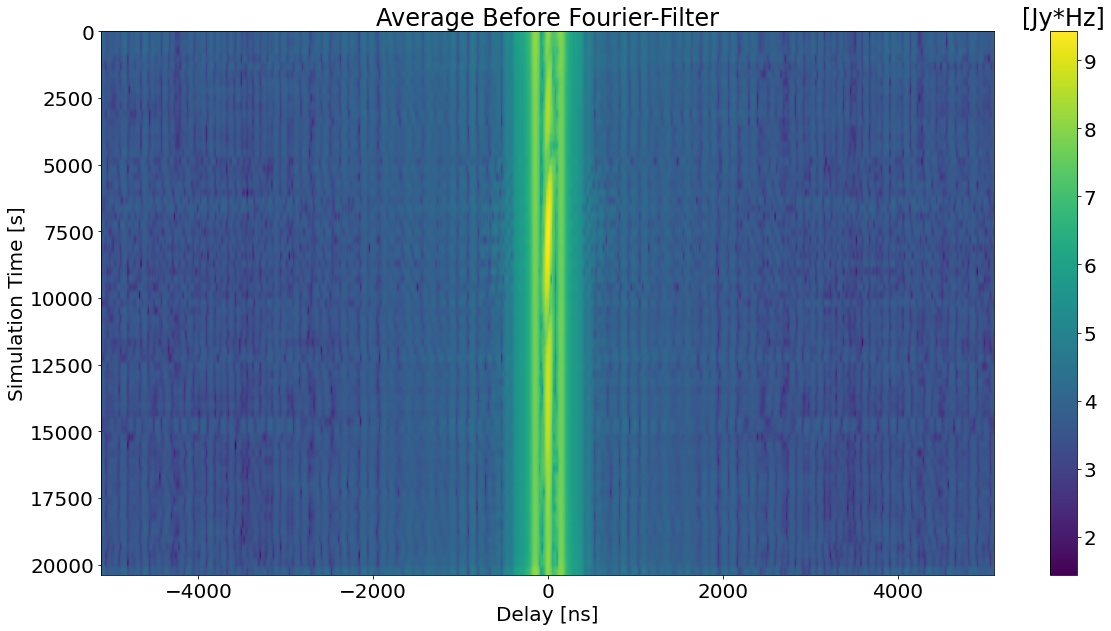

In [11]:
jul = 24*3600
bh = dspec.gen_window('bh',614)
interpolated_times = (avg_bf_data.times - avg_bf_data.times.min())*jul
delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),avg_bf_data.freqs[1] - avg_bf_data.freqs[0]))
ext = (delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min())
plt.imshow(np.log10(np.abs(fft(bh*(avg_bf_data[(11, 14, 'nn')]*(avg_bf_data.freqs[1]-avg_bf_data.freqs[0]))))), extent=ext, aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('[Jy*Hz]')
plt.title('Average Before Fourier-Filter')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')

Text(0, 0.5, 'Simulation Time [s]')

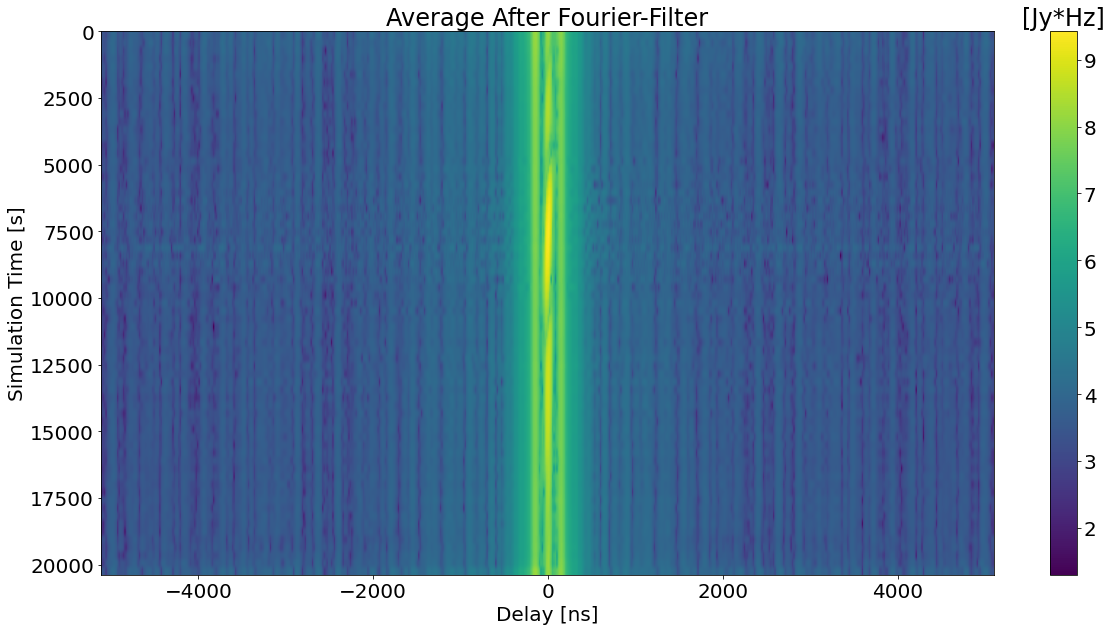

In [12]:
jul = 24*3600
bh = dspec.gen_window('bh',614)
interpolated_times = (avg_af_data.times - avg_af_data.times.min())*jul
delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),avg_af_data.freqs[1] - avg_af_data.freqs[0]))
ext = (delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min())
plt.imshow(np.log10(np.abs(fft(bh*(avg_af_data[(11, 14, 'nn')]*(avg_af_data.freqs[1]-avg_af_data.freqs[0]))))), extent=ext, aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('[Jy*Hz]')
plt.title('Average After Fourier-Filter')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')

In [35]:
# jul = 24*3600
# bh = dspec.gen_window('bh',614)
# interpolated_times = (avg_before_filter.times - avg_before_filter.times.min())*jul
# delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),avg_before_filter.freqs[1] - avg_before_filter.freqs[0]))
# ext = (delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min())
# plt.imshow(np.log10(np.abs(fft(bh*(avg_before_filter[(11, 14, 'nn')]*(avg_before_filter.freqs[1]-avg_before_filter.freqs[0]))))), extent=ext, aspect='auto')
# clb = plt.colorbar()
# clb.ax.set_title('[Jy*Hz]')
# plt.title('Average Before Fourier-Filter')
# plt.xlabel('Delay [ns]')
# plt.ylabel('Simulation Time [s]')

In [77]:
from hera_pspec import utils as uvp_utils
bls1, bls2, blpairs, _, _, red_groups, _, _ = uvp_utils.calc_blpair_reds(avg_before_filter,avg_after_filter,
                                                                   exclude_auto_bls=True,extra_info=True)


red_antpairs = [[] for m in range(np.max(red_groups)+1)]
for group,bl1,bl2 in zip(red_groups,bls1,bls2):
    red_antpairs[group].append((bl1,bl2))
    
    

In [140]:
red_antpairs

[[((0, 11), (1, 12)),
  ((0, 11), (2, 13)),
  ((0, 11), (11, 23)),
  ((0, 11), (12, 24)),
  ((0, 11), (13, 25)),
  ((0, 11), (14, 26)),
  ((0, 11), (23, 36)),
  ((0, 11), (24, 37)),
  ((0, 11), (25, 38)),
  ((0, 11), (26, 39)),
  ((0, 11), (27, 40)),
  ((0, 11), (36, 50)),
  ((0, 11), (37, 51)),
  ((0, 11), (38, 52)),
  ((0, 11), (39, 53)),
  ((0, 11), (40, 54)),
  ((0, 11), (41, 55)),
  ((0, 11), (51, 66)),
  ((0, 11), (52, 67)),
  ((0, 11), (53, 68)),
  ((0, 11), (54, 69)),
  ((0, 11), (55, 70)),
  ((0, 11), (67, 83)),
  ((0, 11), (68, 84)),
  ((0, 11), (69, 85)),
  ((0, 11), (70, 86)),
  ((1, 12), (2, 13)),
  ((1, 12), (11, 23)),
  ((1, 12), (12, 24)),
  ((1, 12), (13, 25)),
  ((1, 12), (14, 26)),
  ((1, 12), (23, 36)),
  ((1, 12), (24, 37)),
  ((1, 12), (25, 38)),
  ((1, 12), (26, 39)),
  ((1, 12), (27, 40)),
  ((1, 12), (36, 50)),
  ((1, 12), (37, 51)),
  ((1, 12), (38, 52)),
  ((1, 12), (39, 53)),
  ((1, 12), (40, 54)),
  ((1, 12), (41, 55)),
  ((1, 12), (51, 66)),
  ((1, 12), (5

In [15]:
psd_before = pspecdata.PSpecData(dsets=[avg_before_filter], beam=airy_beam)
psd_before.Jy_to_mK()
psd_after = pspecdata.PSpecData(dsets=[avg_after_filter], beam=airy_beam)
psd_after.Jy_to_mK()

[array([-6])]
[array([-6])]


In [103]:
red_antpairs2 = [x for x in red_antpairs if x != []]

In [106]:
red_antpairs2[52]

[((2, 66), (14, 83))]

In [107]:
uvp_before = psd_before.pspec(bls1=bls1,
                              bls2=bls2,
                              taper='bh7', dsets=[0,0],pols=('yy','yy'),
                              allow_fft=True, sampling=True,store_window=False,
                              spw_ranges=[(357,562), (20,184)])

uvp_before.average_spectra(time_avg=True,blpair_groups=red_antpairs2)


Setting spectral range: (357, 562)

Using polarization pair: ('yy', 'yy')

(bl1, bl2) pair: ((0, 11), (1, 12))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (2, 13))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (11, 23))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (12, 24))
pol: (-6, -6)
  Building G...
  Building q_hat...

Casting complex values to real discards the imaginary part



  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (13, 25))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (14, 26))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (23, 36))
pol: (-6, -6)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide



(bl1, bl2) pair: ((0, 11), (24, 37))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (25, 38))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (26, 39))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (27, 40))
pol: (-6, -6)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (36, 50))
pol: (-6, -6)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (37, 51))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectr

In [108]:
uvp_after = psd_after.pspec(bls1=bls1,
                              bls2=bls2,
                              taper='bh7', dsets=[0,0],pols=('yy','yy'),
                              allow_fft=True, sampling=True,store_window=False,
                              spw_ranges=[(357,562), (20,184)])

uvp_after.average_spectra(time_avg=True,blpair_groups=red_antpairs2)


Setting spectral range: (357, 562)

Using polarization pair: ('yy', 'yy')

(bl1, bl2) pair: ((0, 11), (1, 12))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (2, 13))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (11, 23))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (12, 24))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (13, 25))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (14, 26))
pol: (-6, -6)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and m

In [34]:
# file_before = 'HERA_CLEAN_NOPRISIM_averagebeforefilter/data_avg_avg_beforefiltered.Cavg.uvh5'
# file_after = 'HERA_CLEAN_NOPRISIM_averageafterfilter/data_avg_avg_afterfiltered.Cavg.uvh5'
# avg_before_filter = HERAData(file_before)
# avg_after_filter = HERAData(file_after)
# avg_bf_data, avg_bf_flags,avg_bf_nsamples = avg_before_filter.read()
# avg_af_data, avg_af_flags,avg_af_nsamples = avg_after_filter.read()
# airy_beam = pspecbeam.PSpecBeamAiry(diameter=14, freqs=avg_after_filter.freqs)



# # for k in avg_bf_nsamples:
# #     if np.all(avg_bf_flags[k]):
# #         print(k)
# #     if np.all(avg_bf_nsamples[k]==0):
# #         print(k)
# #     if np.any(~np.isfinite(avg_bf_data[k])):
# #         print(k)
        
        
# from hera_pspec import utils as uvp_utils
# bls1, bls2, _, _, _, red_groups, _, _ = uvp_utils.calc_blpair_reds(avg_before_filter,avg_before_filter,
#                                                                    exclude_auto_bls=True,extra_info=True)


# red_antpairs = [[] for m in range(np.max(red_groups)+1)]
# for group,bl1,bl2 in zip(red_groups,bls1,bls2):
#     red_antpairs[group].append((bl1,bl2))
    
    
# psd_before = pspecdata.PSpecData(dsets=[avg_before_filter], beam=airy_beam)
# psd_before.Jy_to_mK()
# psd_after = pspecdata.PSpecData(dsets=[avg_after_filter], beam=airy_beam)
# psd_after.Jy_to_mK()


# uvp_before = psd_before.pspec(bls1=bls1,
#                               bls2=bls2,
#                               taper='bh7', dsets=[0,0],pols=('yy','yy'),
#                               allow_fft=True, sampling=True,store_window=False,
#                               spw_ranges=[(357,562), (20,184)])


# uvp_after = psd_after.pspec(bls1=bls1,
#                               bls2=bls2,
#                               taper='bh7', dsets=[0,0],pols=('yy','yy'),
#                               allow_fft=True, sampling=True,store_window=False,
#                               spw_ranges=[(357,562), (20,184)])
                              

Text(0, 0.5, 'Simulation Time [s]')

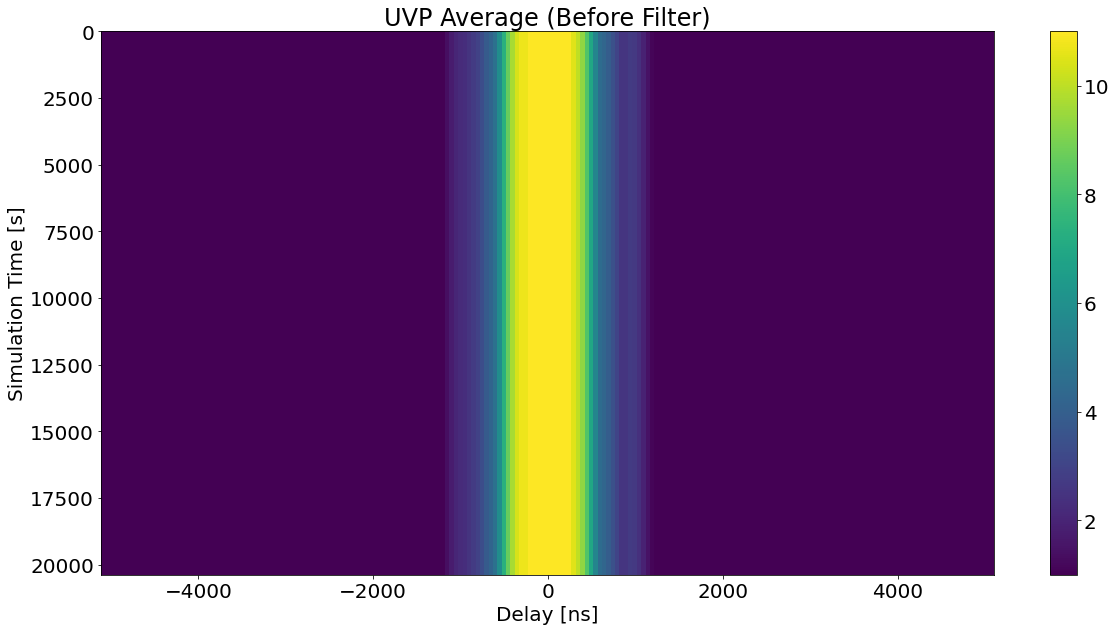

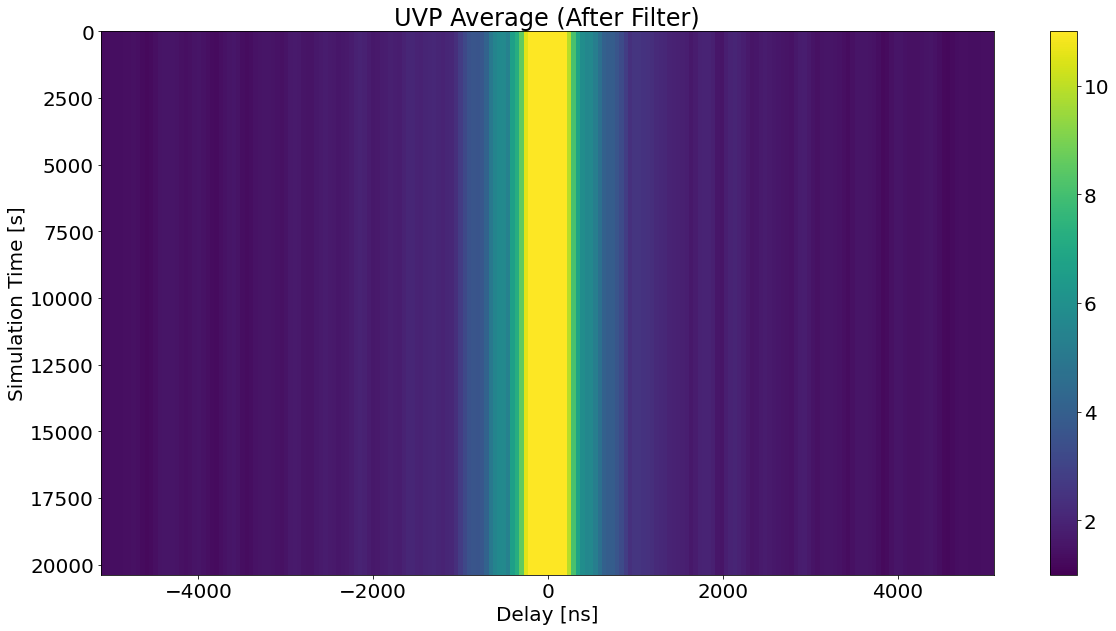

In [154]:
plt.imshow(np.log10(uvp_before.get_data((0,((2, 66), (14, 83)),('yy','yy'))).real), aspect='auto', vmin=1, vmax=11,extent=ext)
plt.colorbar()
plt.title('UVP Average (Before Filter)')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')
plt.figure()
plt.imshow(np.log10(uvp_after.get_data((0,((0,11),(1,12)),('yy','yy'))).real), aspect='auto', vmin=1, vmax=11,extent=ext)
plt.colorbar()
plt.title('UVP Average (After Filter)')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')

(0.0, 1.0)

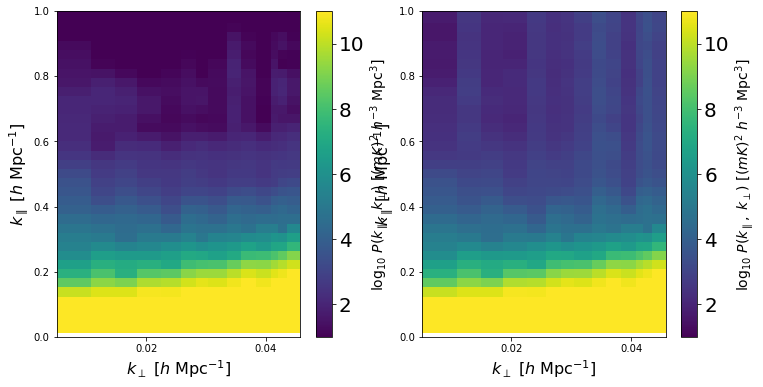

In [109]:
fig,axarray = plt.subplots(1,2)
fig.set_size_inches(12,6)
plt.sca(axarray[0])
handle =pspec_plot.delay_wedge(uvp_before,spw=0,pol=('yy','yy'),fold=True,rotate=True, colorbar=True,
                               vmin=1,vmax=11, ax=axarray[0], delay=False)
plt.gca().set_ylim(0,1)
plt.sca(axarray[1])
handle = pspec_plot.delay_wedge(uvp_after,spw=0,pol=('yy','yy'),fold=True,rotate=True, colorbar=True,
                               vmin=1,vmax=11, ax=axarray[1], delay=False)
plt.gca().set_ylim(0,1)


In [110]:
k_data = uvp_before.get_kparas(0)[104::2]
k_bins = np.diff(k_data)

#print(np.any(np.isnan(uvp_after.data_array[0])))

uvp_before_sph = grouping.spherical_average(uvp_in=uvp_before,kbins=k_data[:-1], bin_widths=k_bins)
uvp_after_sph = grouping.spherical_average(uvp_in=uvp_after,kbins=k_data[:-1], bin_widths=k_bins)

#print(uvp_after_sph.get_blpairs())
#print(uvp_after_sph.get_data((0, ((0, 15), (1, 16)), ('xx', 'xx')))[0])


Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


Text(0.5, 0, '$k$ [$hMpc^{-1}$]')

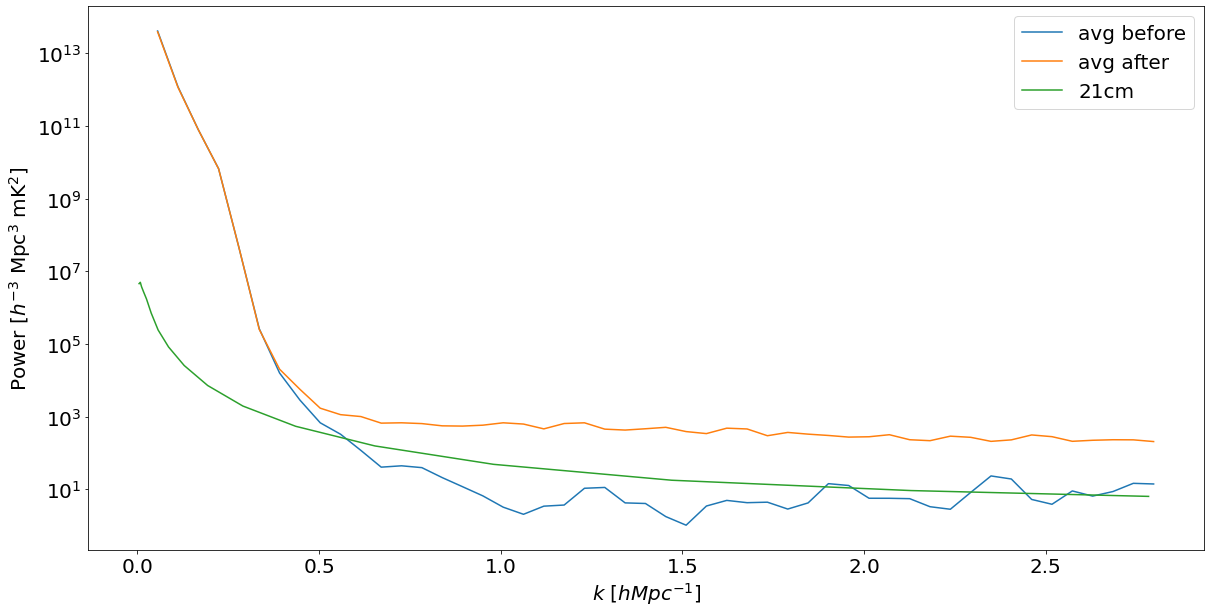

In [172]:
file = 'ps_no_halos_z008.46_nf0.581596_useTs1_NX2.0e-01_alphaX1.5_TvirminX2.0e+05_aveTb001 (1).53_Pop2_1024_1600Mpc_v3'
delta_21 = np.loadtxt(file, usecols=1)
k = np.loadtxt(file,usecols=0)

plt.plot(k_data[:-1], uvp_before_sph.get_data((0, ((0, 11), (1, 12)), ('yy', 'yy')))[0], label='avg before')
plt.plot(k_data[:-1], uvp_after_sph.get_data((0, ((0, 11), (1, 12)), ('yy', 'yy')))[0],label='avg after')
plt.plot(k,(delta_21/k**3)*2*np.pi**2, label='21cm')
plt.yscale('log')
plt.legend()
plt.ylabel('Power [$h^{-3}$ Mpc$^3$ mK$^2$]')
plt.xlabel('$k$ [$hMpc^{-1}$]')

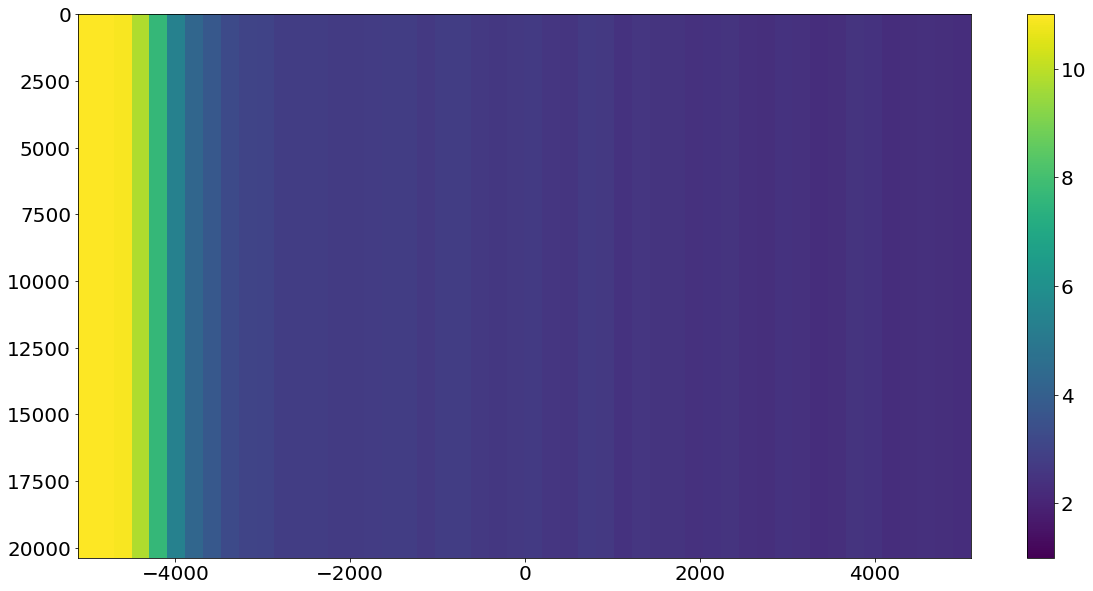

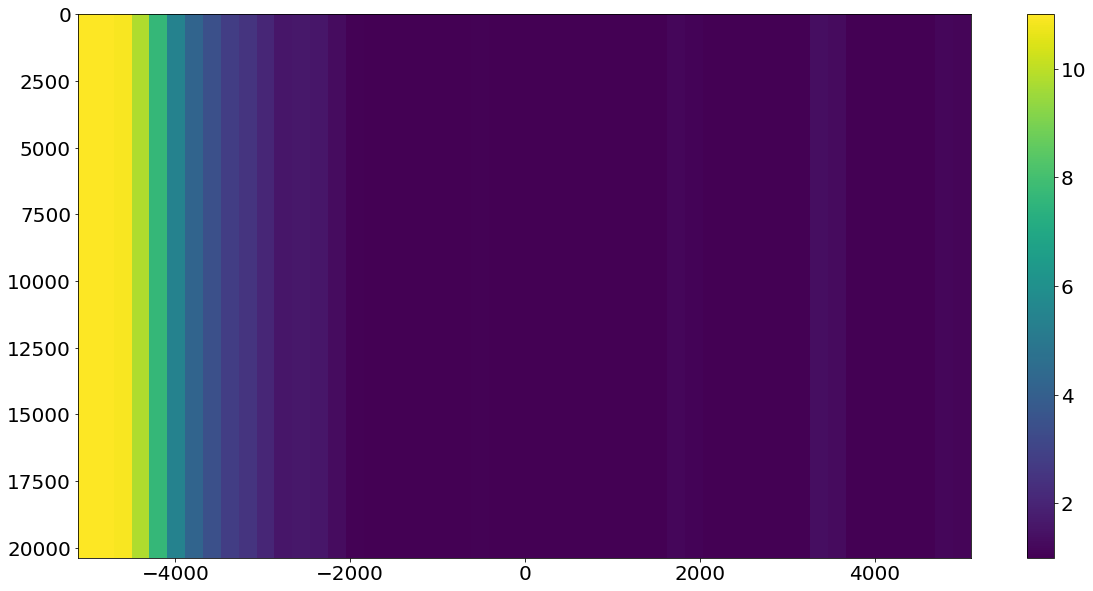

In [127]:
plt.figure()
plt.imshow(np.log10(uvp_after_sph.get_data((0,((0,11),(1,12)),('yy','yy'))).real), aspect='auto', vmin=1, vmax=11, extent=ext)
plt.colorbar()
plt.figure()
plt.imshow(np.log10(uvp_before_sph.get_data((0,((0,11),(1,12)),('yy','yy'))).real), aspect='auto', vmin=1, vmax=11, extent=ext)
plt.colorbar()